### TODO:
- Put correlation between apps? Useful?

### Done/dismissed but recorded:
- Try demeaning all series? - doesn't work well.
- Why do plots have such different proportions of houses? - because three homes have data for *all* time periods.
- Changed kettle on_power_threshold to 1500 (from 2000) since it wasn't catching activations for house 3.
- Figure out why house 3/5/20 has inverse fridge pattern. - not sure but can look into it later
- Bayesian opt for hyperparameter selection - would take too much time and needs to be done all at once (as opposed to random search)
- Visualize activations.
- Look at LBM paper for error. (???)
- Look at where model is getting things wrong. Make function that plots largest/pathological errors.
- Add x=y line to predictions vs. actual. - Just set xlim and ylim equal and tried to make plots square

In [1]:
from __future__ import division

from utils import *
from create_data import *
from build_models import *

import os
import sys
import pandas as pd
import numpy as np
from collections import OrderedDict
import time
from datetime import datetime, date, timedelta
from dateutil.parser import parse
import re
from decimal import Decimal
import warnings

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import keras
from keras import backend as K
from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint, LambdaCallback
from keras.utils import plot_model
from keras import regularizers

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

%matplotlib inline
matplotlib.style.use('ggplot')

Using TensorFlow backend.


In [2]:
dir_proj = '/Users/sipola/Google Drive/education/coursework/graduate/edinburgh/dissertation/thesis'
dir_data = os.path.join(dir_proj, 'data')
dir_for_model = os.path.join(dir_data, 'for_model')
dir_for_model_real = os.path.join(dir_for_model, 'real')
dir_for_model_synth = os.path.join(dir_for_model, 'synthetic')
dir_models = os.path.join(dir_data, 'models')
dir_run = os.path.join(dir_proj, 'run', str(date.today()))
path_daily_stats = os.path.join(dir_data, 'stats_by_day.pkl')

In [3]:
N_PER_DAY = 14400  # 24 * 60 * 60 / 6
HOUSE_IDS, HOUSE_IDS_TEST_UNSEEN, HOUSE_IDS_NOT_TEST_UNSEEN, HOUSE_IDS_SOLAR = get_house_id_groups()
HOUSE_IDS_NOT_SOLAR = [house_id for house_id in HOUSE_IDS if house_id not in HOUSE_IDS_SOLAR]
# TRAIN_VAL_DATE_MAX = date(2015,2,28)
APP_NAMES = ['fridge', 'kettle', 'washing machine', 'dishwasher', 'microwave']
TRAIN_DTS = np.load(os.path.join(dir_for_model_synth, 'train_dts.npy'))
TARGET_TYPES = ['energy', 'activations']

In [4]:
take_diff = False
# val_prop = 0.2
train_dates = [dt.date() for dt in TRAIN_DTS]
extreme_percentile_cutoff = 100

In [182]:
np.random.seed(20170627)

dstats = pd.read_pickle(path_daily_stats)
dstats = clean_daily_stats(dstats, is_debug=False)

all_data = prepare_real_data(dir_for_model_real,
                             dstats,
                             HOUSE_IDS_SOLAR,
                             HOUSE_IDS_NOT_TEST_UNSEEN,
                             HOUSE_IDS_TEST_UNSEEN,
                             train_dates)

all_data = prepare_synth_data(dir_for_model_synth,
                              all_data = all_data)

# Want to take diffs before making scalers.
if take_diff:
    print 'taking diffs...'
    for key, dat in all_data.iteritems():
        all_data[key]['X'] = take_diff_df(dat['X'])

print 'creating scalers...'
scaler_real, scaler_synth, scaler_both = create_scalers(all_data)

print 'scaling validation and test data...'
for split_type in ['val', 'test_seen', 'test_unseen']:
    all_data[split_type]['X'] = scaler_real.transform(all_data[split_type]['X'])
    all_data[split_type]['X'] = scaler_both.transform(all_data[split_type]['X'])

processing real data...
removing homes with solar panels...
removing obs where correlation between main and sum of apps is low...
removed 15 obs (0.21% of total)
removing obs where agg value is repeated...
removed 86 obs (1.2% of total)
splitting into training, validation/test (seen) and test (unseen)...
-----
0.492834623101 training
0.160361134996 validation, seen (combined)
0.160361134996 test, seen (combined)
0.186443106907 test, unseen
True
-----
splitting validation/test (seen) into validation and test (seen)...
val <type 'dict'>
    Y1: (1119, 5)
    X: (1119, 14400)
    Y2: (1119, 5)
    x_date: (1119,)
    x_house: (1119,)
    houses: [3, 4, 6, 7, 8, 9, 10, 12, 13, 16, 17, 18, 19, 20]
    missing houses: [1, 2, 5, 11, 15, 21]
    num. unique days: 211
    has training dates: False
    has non-training dates: True

synth_train_all <type 'dict'>
    Y1: (42010, 5)
    X: (42010, 14400)
    Y2: (42010, 5)
    x_date: (42010,)
    x_house: (42010,)
    houses: [1, 3, 4, 6, 7, 8, 9,

In [6]:
dir_refit_csv = os.path.join(dir_data, 'CLEAN_REFIT_081116')
dir_refit = os.path.join(dir_data, 'refit')

apps = pd.read_csv(os.path.join(dir_data, 'appliances.csv'))
app_dict = create_app_dict()
apps = apps_add_cols_from_patterns(apps, app_dict)

get_house_app_tuples, get_app_nums, get_app_name, is_a_target_app, get_standardized_app_names = create_app_funs(apps, app_dict, APP_NAMES)
load_app, load_ts, load_issues = create_load_funs(dir_refit)

In [84]:
# def app_names_to_plot_name(app_names):
#     return app_names[0] if app_names != APP_NAMES else 'all'

# fig = plt.figure(figsize=(8,6))
# ax = fig.add_subplot(111)

# # matplotlib.cm.plasma((colors-np.min(colors))/(np.max(colors)-np.min(colors)))
# apps_to_plot = [[app_name] for app_name in APP_NAMES] + [APP_NAMES]
# # color_idx = np.linspace(0, 1, len(apps_to_plot))
# color_idx = range(len(apps_to_plot))
# # cm = plt.cm.Set1
# cm = plt.cm.tab10

# all_random_curves = []
# modeling_group_name = 'main'
# for apps_color_idx, app_names in enumerate(apps_to_plot):
#     for target_type in ['energy', 'activations']:
#         linestyle = '-' if target_type=='energy' else '--'
#         dir_models_set = os.path.join(dir_models, modeling_group_name, target_type, app_names_to_filename(app_names))
#         hist_and_params = get_histories_df(dir_models_set).reset_index()
#         hist_and_params['model'] = hist_and_params['model'].str.replace('model_', '').apply(pd.to_numeric)
#         hist_and_params.sort_values('model', inplace=True)
#         # print app_names_to_filename(app_names), hist_and_params.shape
#         all_random_curves_one = pd.DataFrame.from_dict({
#             'target_type': target_type,
#             'app_names': app_names_to_plot_name(app_names),
#             'model': hist_and_params['model'],
#             'val_loss': cummin(hist_and_params['val_loss'])
#         })
#         # print all_random_curves_one
#         plot_args = {
#             'x': 'model',
#             'y': 'val_loss',
#             'kind': 'line',
#             'drawstyle': 'steps-pre',
#             'color': cm(color_idx[apps_color_idx]),
#             'linestyle': linestyle,
#             'label': '{} - {}'.format(app_names_to_plot_name(app_names), target_type)
#         }
#         all_random_curves_one.plot(ax=ax, **plot_args)
#         all_random_curves.append(all_random_curves_one)
# plt.ylabel('Best validation error')
# plt.xlabel('Model run')
# plt.title('Best validation error for all models up to model run')
# all_random_curves = pd.concat(all_random_curves)
# # plt.savefig(os.path.join(dir_run, 'random_search_best_val_error.pdf'))

In [9]:
def app_names_to_plot_name(app_names):
    if isinstance(app_names, basestring):
        return app_names
    elif len(app_names)==1:
        return app_names[0]
    elif app_names == APP_NAMES:
        return 'all target appliances'
    else:
        return ', '.join(app_names)

total number of models: 37


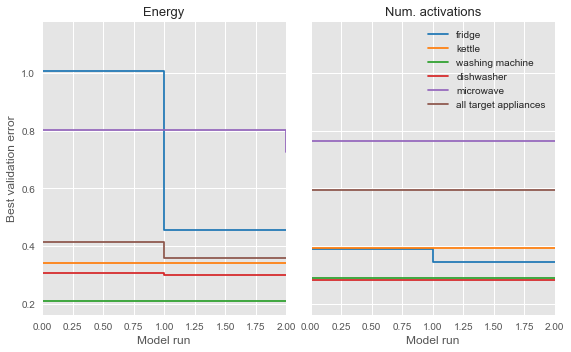

In [188]:
# Plot best validation errors.
# Two try statements below are for catching cases where folders don't exist.

figsize = (8,5)

fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=figsize)

apps_to_plot = [[a] for a in APP_NAMES] + [APP_NAMES]
# color_idx = np.linspace(0, 1, len(apps_to_plot))
color_idx = range(len(apps_to_plot))
cm = plt.cm.tab10

all_random_curves = []
modeling_group_name = 'main'
for plot_idx, target_type in enumerate(['energy', 'activations']):
    ax = axes[plot_idx]
    for apps_color_idx, app_names in enumerate(apps_to_plot):
        dir_models_set = os.path.join(dir_models, modeling_group_name, target_type, app_names_to_filename(app_names))
        try:
            hist_and_params = get_histories_df(dir_models_set).reset_index()
        except OSError:
            continue
        hist_and_params['model'] = hist_and_params['model'].str.replace('model_', '').apply(pd.to_numeric)
        hist_and_params.sort_values('model', inplace=True)
        # print app_names_to_filename(app_names), hist_and_params.shape
        all_random_curves_one = pd.DataFrame.from_dict({
            'target_type': target_type,
            'app_names': app_names_to_plot_name(app_names),
            'model': hist_and_params['model'],
            'val_loss': cummin(hist_and_params['val_loss'])
        })
        plot_args = {
            'x': 'model',
            'y': 'val_loss',
            'kind': 'line',
            'drawstyle': 'steps-pre',
            'color': cm(color_idx[apps_color_idx]),
            'label': '{}'.format(app_names_to_plot_name(app_names))
        }
        all_random_curves_one.plot(ax=ax, **plot_args)
        all_random_curves.append(all_random_curves_one)
        
    ax.set_title((target_type if target_type=='energy' else 'num. activations').capitalize(), size=13)
    ax.set_ylabel('Best validation error')
    ax.set_xlabel('Model run')
    if plot_idx == 0:
        try:
            ax.legend().set_visible(False)
        except AttributeError:
            pass

fig.tight_layout()
# plt.suptitle('Best validation error in random search', size=16)
# fig.subplots_adjust(top=0.87)  # NEED THIS?!!!!!!!!!!??????!?!??!??!?!?!?!??!??!!?!?!?!?!
all_random_curves = pd.concat(all_random_curves)
makedirs2(dir_run)
plt.savefig(os.path.join(dir_run, 'random_search_best_val_error.pdf'))

print 'total number of models: {}'.format(all_random_curves.shape[0])

In [105]:
# Create data to for LaTeX table describing architectures.

modeling_group_name = 'main_old'

app_names_list = [[a] for a in APP_NAMES] + [APP_NAMES]

num_params_name = 'number of parameters'
randomized_params = [
    'num_conv_layers',
    'num_dense_layers',
    'start_filters',
    'kernel_size',
    'strides',
    'pool_size',
    'last_dense_layer_size',
    'learning_rate',
    'l2_penalty',
    num_params_name
]

params_df = []
for target_type in TARGET_TYPES:
    print target_type
    for app_names in app_names_list:
        print '    {}'.format(app_names)
        dir_models_set = os.path.join(dir_models, modeling_group_name, target_type, app_names_to_filename(app_names))
        model_name = get_best_model_name(dir_models_set)
        params_this = pickle.load(open(os.path.join(dir_models_set, model_name, 'params.pkl'), 'rb'))
        params_this[num_params_name] = load_best_model(dir_models_set).count_params()  # takes a while
        params_df_this = pd.DataFrame.from_dict(params_this, orient='index').reset_index()
        params_df_this.columns = ['param', 'value']
        params_df_this['app_name'] = app_names_to_plot_name(app_names)
        params_df_this['target_type'] = target_type
        params_df.append(params_df_this)
        
params_df = pd.concat(params_df)
params_df = params_df.reset_index().drop('index', axis=1)  # resets numbering of index
params_df = params_df.loc[params_df['param'].isin(randomized_params)]

params_df.set_index(['app_name', 'target_type'], inplace=True)  # for pivot
params_df = params_df.pivot(columns='param')  # set to wide
params_df.columns = params_df.columns.droplevel()
params_df = params_df[randomized_params]  # reorder columns so most important are first

energy
    ['fridge']
    ['kettle']
    ['washing machine']
    ['dishwasher']
    ['microwave']
    ['fridge', 'kettle', 'washing machine', 'dishwasher', 'microwave']
activations
    ['fridge']
    ['kettle']
    ['washing machine']
    ['dishwasher']
    ['microwave']
    ['fridge', 'kettle', 'washing machine', 'dishwasher', 'microwave']


In [158]:
num_params_name

'number of parameters'

In [430]:
# Create LaTeX table with params.

for target_type in TARGET_TYPES:

    params_target = params_df.drop(labels=target_type, level=1, axis=0)
    params_target.index = params_target.index.droplevel(1)
    params_target = params_target.reindex(APP_NAMES + [app_names_to_plot_name(APP_NAMES)])

    # Need this in latex document: \newcommand*\rot{\rotatebox{90}}
    t = []
    t.append('\\begin{center}')
    t.append('\\begin{tabular}{' + ' l | ' + 'c '*(params_target.shape[1]-1) + '|c' + '}')
    rotated_cols = ['\\rot{\\texttt{' + v + '}}' if v!=num_params_name else '\\rot{'+v+'}' for v in params_target.columns.values]
    t.append(' & ' + ' & '.join(rotated_cols) + ' \\\\')
    t.append('\\hline')
    for i, row in enumerate(params_target.iterrows()):
        param_name = params_target.index.values[i]
        row_pretty = ['{:0.2g}'.format(v) if v >= 1 else '{:0.1e}'.format(Decimal(v)) for v in row[1].values]
        row_pretty = [param_name] + row_pretty
        t.append(' & '.join(row_pretty) + ' \\\\')
    t.append('\\end{tabular}')
    t.append('\\end{center}')
    
    print '\n'
    print target_type
    print '\n'
    print '\n'.join(t)



energy


\begin{center}
\begin{tabular}{ l | c c c c c c c c c |c}
 & \rot{\texttt{num_conv_layers}} & \rot{\texttt{num_dense_layers}} & \rot{\texttt{start_filters}} & \rot{\texttt{kernel_size}} & \rot{\texttt{strides}} & \rot{\texttt{pool_size}} & \rot{\texttt{last_dense_layer_size}} & \rot{\texttt{learning_rate}} & \rot{\texttt{l2_penalty}} & \rot{number of parameters} \\
\hline
fridge & 6 & 2 & 6 & 6 & 1 & 3 & 23 & 1.2e-3 & 0.0e+1 & 3.3e+05 \\
kettle & 6 & 1 & 7 & 4 & 1 & 3 & 25 & 7.2e-4 & 0.0e+1 & 2.5e+05 \\
washing machine & 6 & 2 & 7 & 4 & 1 & 3 & 19 & 3.7e-4 & 0.0e+1 & 3.1e+05 \\
dishwasher & 6 & 1 & 4 & 4 & 2 & 2 & 25 & 1.8e-3 & 2.6e-5 & 5.7e+04 \\
microwave & 4 & 1 & 5 & 4 & 1 & 4 & 13 & 2.1e-3 & 0.0e+1 & 3.4e+04 \\
all target appliances & 5 & 1 & 15 & 12 & 1 & 3 & 21 & 4.2e-4 & 0.0e+1 & 7.6e+05 \\
\end{tabular}
\end{center}


activations


\begin{center}
\begin{tabular}{ l | c c c c c c c c c |c}
 & \rot{\texttt{num_conv_layers}} & \rot{\texttt{num_dense_layers}} & \rot{\te

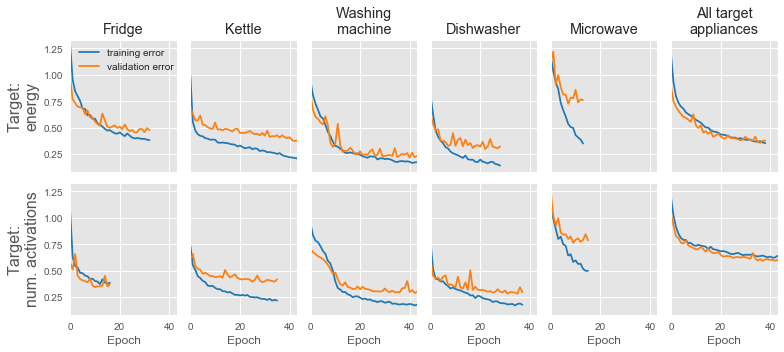

In [190]:
# Create error curves.

cm = plt.cm.tab10

modeling_group_name = 'main'

# for modeling_group_name in ['main', 'more_patience']:

app_names_list = [[a] for a in APP_NAMES] + [APP_NAMES]

fig = plt.figure(figsize=(11,5))
gs = matplotlib.gridspec.GridSpec(nrows=2, ncols=len(app_names_list))

histories = []
plot_num = 0
for target_type in TARGET_TYPES:
    # print target_type
    for app_names in app_names_list:
        # print '    {}'.format(app_names)
        dir_models_set = os.path.join(dir_models, modeling_group_name, target_type, app_names_to_filename(app_names))
        model_name = get_best_model_name(dir_models_set)
        history = pd.DataFrame.from_csv(os.path.join(dir_models_set, model_name, 'history.csv'))

        if plot_num==0:
            ax = fig.add_subplot(gs[plot_num])
        else:
            ax = fig.add_subplot(gs[plot_num], sharey=ax, sharex=ax)

        history.rename(columns={'loss': 'training error', 'val_loss': 'validation error'}, inplace=True)
        try:
            history.drop('runtime', axis=1, inplace=True)
        except ValueError:
            pass
        history.plot(ax=ax, color=[cm(0), cm(1)])

        if target_type==TARGET_TYPES[0]:
            if app_names==APP_NAMES:
                app_names_pretty = 'all target\nappliances'
            elif app_names==['washing machine']:
                app_names_pretty = 'washing\nmachine'
            else:
                app_names_pretty = app_names[0]
            ax.set_title('{}'.format(app_names_pretty).capitalize())
            ax.set_xlabel('')
        else:
            ax.set_xlabel('Epoch')

        if app_names==[APP_NAMES[0]]:
            ax.set_ylabel('Target:\nenergy' if target_type=='energy' else 'Target:\nnum. activations', size=16)


        if plot_num > 0:
            ax.get_legend().set_visible(False)

        plot_num += 1

gs.tight_layout(fig)

makedirs2(dir_run)
plt.savefig(os.path.join(dir_run, 'error_curves.pdf' if modeling_group_name=='main' else 'error_curves_{}.pdf'.format(modeling_group_name)))

plt.show()

In [280]:
# # Fix corruption of params.pkl for main - energy - fridge - model_16 (best performing model)

# params = {
#     'num_conv_layers': 7,
#     'num_dense_layers': 1,
#     'start_filters': 6,
#     'deepen_filters': True,
#     'kernel_size': 5,
#     'strides': 1,
#     'dilation_rate': 1,
#     'do_pool': True,
#     'pool_size': 2,
#     'last_dense_layer_size': 9,
#     'dropout_rate_after_conv': 0.5,
#     'dropout_rate_after_dense': 0.25,
#     'use_batch_norm': False,
#     'optimizer': keras.optimizers.Adam,
#     'learning_rate': 0.000597416,
#     'l2_penalty': 0,
#     'hidden_layer_activation': 'relu',
#     'output_layer_activation': 'relu',
#     'loss': 'mse'
# }

# pickle.dump(params, open(os.path.join(os.path.join(dir_models, 'main', 'energy', 'fridge', 'model_16'), 'params.pkl'), 'wb'))

In [287]:
# Test the effect of increasing patience.

modeling_group_name_old = 'main'
modeling_group_name_new = 'more_patience'

for target_type in TARGET_TYPES:
    print target_type
    for app_names in app_names_list:
        print '    {}'.format(app_names)
        
        if target_type=='energy' and app_names==['fridge']:
            continue
        
        dir_models_set_old = os.path.join(dir_models, modeling_group_name_old, target_type, app_names_to_filename(app_names))
        model_name = get_best_model_name(dir_models_set_old)
        print model_name
        run_models(
            all_data,
            target_type,  # 'energy' or 'activations'
            app_names,
            APP_NAMES,
            dir_models,
            params_function = None,  # !
            modeling_group_name = modeling_group_name_new,  # !
            models_to_run = 1,  # !
            epochs = 100,
            batch_size = 32,
            continue_from_last_run = True,
            total_obs_per_epoch = 8192,
            real_to_synth_ratio = 0.5,
            patience = 12,  # NEW!
            checkpointer_verbose = 0,
            fit_verbose = 0,
            show_plot = False,
            print_summary = True,
            model_init_dir = os.path.join(dir_models_set_old, model_name)
        )

energy
    ['fridge']
    ['kettle']
model_21
model_0
                                                        0
loss                                                  mse
hidden_layer_activation                              relu
last_dense_layer_size                                  16
optimizer                 <class 'keras.optimizers.Adam'>
num_dense_layers                                        2
do_pool                                              True
num_conv_layers                                         6
learning_rate                                 0.000425154
output_layer_activation                              relu
deepen_filters                                       True
pool_size                                               4
dropout_rate_after_dense                             0.25
dilation_rate                                           1
start_filters                                           8
use_batch_norm                                      False
strides           

In [310]:
# Test effect of synthetic data

modeling_group_name_old = 'main'
modeling_group_name_new = 'no_synth'

for target_type in TARGET_TYPES:
    print target_type
    for app_names in app_names_list:
        print '    {}'.format(app_names)
        
        dir_models_set_old = os.path.join(dir_models, modeling_group_name_old, target_type, app_names_to_filename(app_names))
        model_name = get_best_model_name(dir_models_set_old)
        print model_name
        run_models(
            all_data,
            target_type,
            app_names,
            APP_NAMES,
            dir_models,
            params_function = None,  # !
            modeling_group_name = modeling_group_name_new,  # !
            models_to_run = 1,  # !
            epochs = 100,
            batch_size = 32,
            continue_from_last_run = True,
            total_obs_per_epoch = 8192,
            real_to_synth_ratio = 1,  # !!!!!!!!!!!!!!!
            patience = 5,
            checkpointer_verbose = 0,
            fit_verbose = 0,
            show_plot = False,
            print_summary = True,
            model_init_dir = os.path.join(dir_models_set_old, model_name)
        )

energy
    ['fridge']
model_16
model_0
                                                        0
loss                                                  mse
hidden_layer_activation                              relu
last_dense_layer_size                                   9
optimizer                 <class 'keras.optimizers.Adam'>
num_dense_layers                                        1
do_pool                                              True
num_conv_layers                                         7
learning_rate                                 0.000597416
output_layer_activation                              relu
deepen_filters                                       True
pool_size                                               2
dropout_rate_after_dense                             0.25
dilation_rate                                           1
start_filters                                           6
use_batch_norm                                      False
strides                          

In [122]:
# Score best performing models. Also store models and predictions for later.

modeling_group_name = 'main'
data_set = 'test'

app_names_list = [[a] for a in APP_NAMES] + [APP_NAMES]
# app_names_list = [APP_NAMES]

perf = {}
preds = {}
models = {}
for target_type in TARGET_TYPES:
    print target_type
    perf[target_type] = {}
    preds[target_type] = {}
    models[target_type] = {}
    Y_key = 'Y1' if target_type=='energy' else 'Y2'
    for app_names in app_names_list:
        
        app_names_pretty = app_names_to_plot_name(app_names)
        print '    {}'.format(app_names_pretty)
        
        perf[target_type][app_names_pretty] = {}
        preds[target_type][app_names_pretty] = {}
        
        dir_models_set = os.path.join(dir_models, modeling_group_name, target_type, app_names_to_filename(app_names))
        model_name = get_best_model_name(dir_models_set)
        model = load_best_model(dir_models_set)
        models[target_type][app_names_pretty] = model
        target_scaler = pickle.load(open(os.path.join(dir_models_set, model_name, 'target_scaler.pkl'), 'rb'))

        app_idx = [APP_NAMES.index(app_name) for app_name in app_names]

        for house_type in ['All', 'Seen houses', 'Unseen houses']:
            if house_type == 'All':
                mask = np.ones(all_data[data_set]['X'].shape[0], dtype=bool)
                # mask = True
            elif house_type == 'Seen houses':
                mask = np.in1d(all_data[data_set]['x_house'], HOUSE_IDS_TRAIN)
            elif house_type == 'Unseen houses':
                mask = np.in1d(all_data[data_set]['x_house'], HOUSE_IDS_VAL_TEST)
            else:
                raise ValueError('Unrecognized house_type!')
            # print '        {}'.format(house_type)
            X = reshape_as_tensor(all_data[data_set]['X'][mask])
            Y = all_data[data_set][Y_key][:,app_idx][mask]
            Y_trans = target_scaler.transform(Y)
            
            perf[target_type][app_names_pretty][house_type] = model.evaluate(X, Y, verbose=0)
            Y_hat_trans = model.predict(X)
            Y_hat = target_scaler.inverse_transform(Y_hat_trans)
            preds[target_type][app_names_pretty][house_type] = ((Y, Y_hat), (Y_trans, Y_hat_trans))

energy
    fridge
    kettle
    washing machine
    dishwasher
    microwave
    all target appliances
activations
    fridge
    kettle
    washing machine
    dishwasher
    microwave
    all target appliances


In [15]:
# dir_tmp = os.path.join(dir_data, 'tmp')
# makedirs2(dir_tmp)

# pickle.dump(perf, open(os.path.join(dir_tmp, 'perf.pkl'), 'wb'))
# pickle.dump(preds, open(os.path.join(dir_tmp, 'preds.pkl'), 'wb'))
# pickle.dump(models, open(os.path.join(dir_tmp, 'models.pkl'), 'wb'))

# perf = pickle.load(open(os.path.join(dir_tmp, 'perf.pkl'), 'wb'))
# preds = pickle.load(open(os.path.join(dir_tmp, 'preds.pkl'), 'wb'))
# models = pickle.load(open(os.path.join(dir_tmp, 'models.pkl'), 'wb'))

In [123]:
# Choose observation with most "interesting" signals: lots of energy used by
# the appliances and predictions are accurate.

# Only works for len(app_names)==1

Y_df = []  # DataFrame of predictions 
for target_type in TARGET_TYPES:
    for app_name in APP_NAMES:
        target_scaler
        Y, Y_hat = preds[target_type][app_name]['All'][1]
        Y_df_this = pd.DataFrame.from_dict({'Y': Y.ravel()})
        Y_df_this['Y_hat'] = Y_hat.ravel()
        Y_df_this['target_type'] = target_type
        Y_df_this['app_name'] = app_name
        Y_df_this['obs'] = range(Y_hat.shape[0])
        Y_df.append(Y_df_this)
Y_df = pd.concat(Y_df)
Y_df.set_index('obs', inplace=True)
Y_df.tail()

,Y,Y_hat,target_type,app_name
obs,,,,
1004,0.369957,0.723766,activations,microwave
1005,0.739913,0.678869,activations,microwave
1006,1.109870,0.201388,activations,microwave
1007,0.000000,0.074314,activations,microwave
1008,0.000000,0.065043,activations,microwave


In [124]:
alpha = 0.75  # amount of weight to put on having low errors vs. having high energy.
min_energy = 0.5  # minimum amount of energy *all* appliances need to use to be included; this is a scaled number, 0 to ~8 for most appliances

Y_wide = {}
for target_type in TARGET_TYPES:
    Y_wide[target_type] = {}
    for Y_type in ['Y', 'Y_hat']:
        Y_wide[target_type][Y_type] = \
            Y_df.loc[Y_df['target_type']==target_type].pivot(columns='app_name', values=Y_type)

# Determine how good predictions were.
pred_scores_energy = -np.sqrt(np.abs(Y_wide['energy']['Y'] - Y_wide['energy']['Y_hat']))
pred_scores_energy = pred_scores_energy.mean(axis=1)

pred_scores_activations = -np.sqrt(np.abs(Y_wide['activations']['Y'] - Y_wide['activations']['Y_hat']))
pred_scores_activations = pred_scores_activations.mean(axis=1)

pred_scores = pred_scores_activations + pred_scores_energy  # this is negative: higher is better

# Determine how much energy was used.
high_energy_scores = np.sqrt(Y_wide['energy']['Y']).mean(axis=1)

# Only keep house/date combos where all appliances were used quite a bit.
all_used = (Y_wide['energy']['Y'] > min_energy).all(axis=1)

# Determine best observations: lots of energy was used and predictions were accurate.
 
score = (1-alpha)*StandardScaler().fit_transform(high_energy_scores.values.reshape(-1,1))
score += alpha*StandardScaler().fit_transform(pred_scores.values.reshape(-1,1))
obs_scores = pd.DataFrame({
    'obs': range(len(high_energy_scores.values)),
    'score': score.ravel()
})
    
obs_scores = obs_scores.loc[all_used]
obs_scores.sort_values('score', ascending=False, inplace=True)
print 'number of obs: {}'.format(obs_scores.shape[0])
obs_scores.iloc[:10]

number of obs: 88


,obs,score
531,531,0.888906
799,799,0.599353
739,739,0.543214
40,40,0.424165
183,183,0.348249
584,584,0.320189
554,554,0.296407
544,544,0.264678
144,144,0.243693
886,886,0.240389


In [143]:
obs = obs_scores.index[-1]  # one of the better predictions
print all_data['test']['x_house'][obs]
print all_data['test']['x_date'][obs]

2
2014-05-21


In [116]:
# df = pd.DataFrame({'start': [dt_start], 'end': [dt_end]})
# df['start'] = pd.to_datetime(df['start'], unit='s', utc=True)
# df['end'] = pd.to_datetime(df['end'], unit='s', utc=True)
# df['diff'] = df['end'] - df['start']
# df['diff']
# df

,end,start
0,2015-01-01 18:00:00,2015-01-01 12:00:00


In [91]:
# activations
# dt_start = datetime(2015,1,1,12)
# dt_end = datetime(2015,1,1,18)
# dt_start
# dt_start - floor_time(date_to_datetime(dt_start))
# floor_time(date_to_datetime(dt_start)) + timedelta(days=1) - dt_end
# # floor_time(date_to_datetime(dt_start)) + timedelta(days=1)

datetime.timedelta(0, 21600)

observation: 626


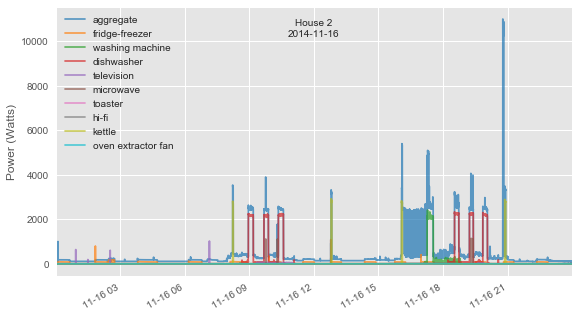

energy
fridge
actual = 0.800761388889, predicted = 0.652285397053
shape of activations: (10, 225)


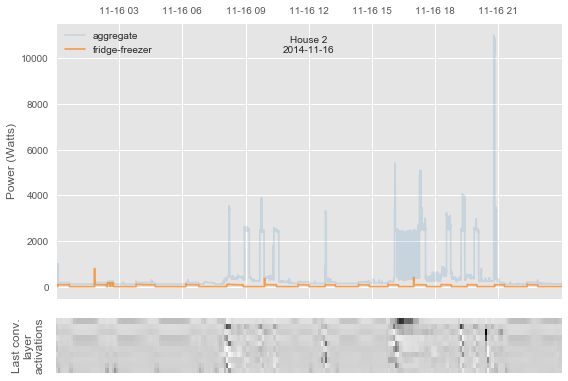

energy
kettle
actual = 0.396743333333, predicted = 0.339523613453
shape of activations: (10, 15)


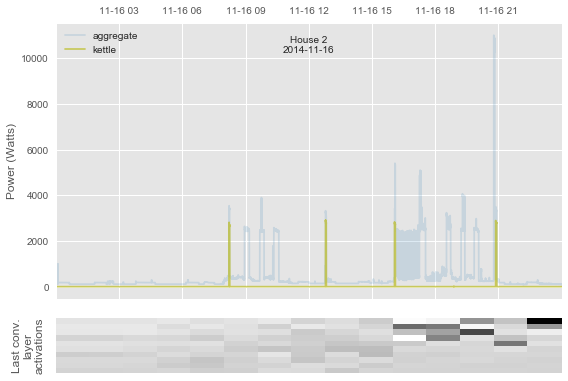

energy
washing machine
actual = 0.722679444444, predicted = 0.519935667515
shape of activations: (10, 57)


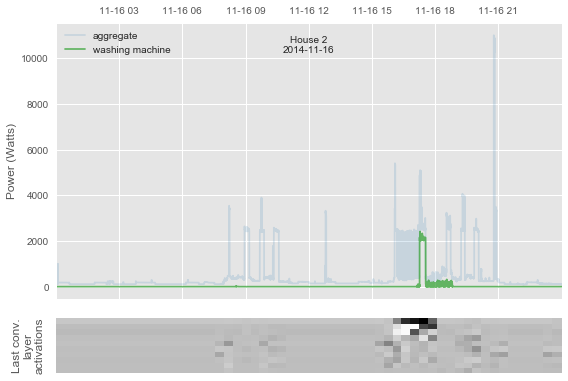

energy
dishwasher
actual = 2.93954305556, predicted = 2.67281079292
shape of activations: (10, 60)


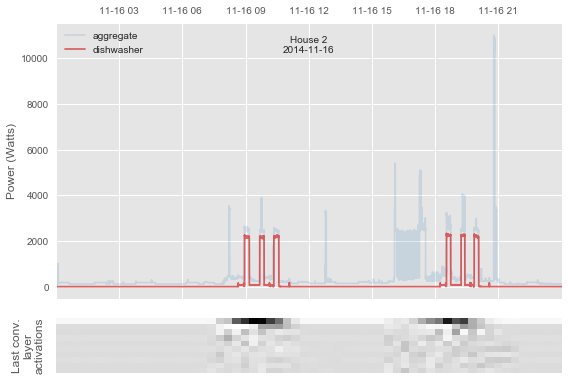

energy
microwave
actual = 0.0711780555556, predicted = 0.0595473572612
shape of activations: (10, 113)


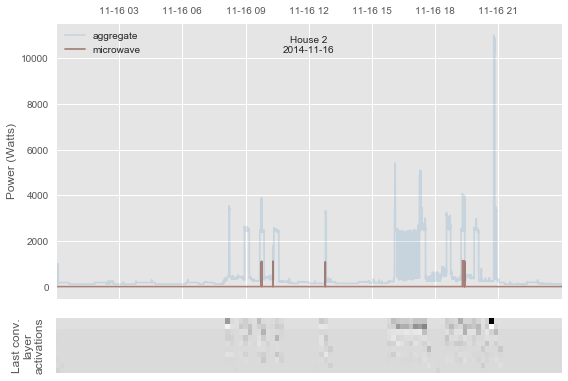

activations
fridge
actual = 16, predicted = 18.7732639313
shape of activations: (10, 60)


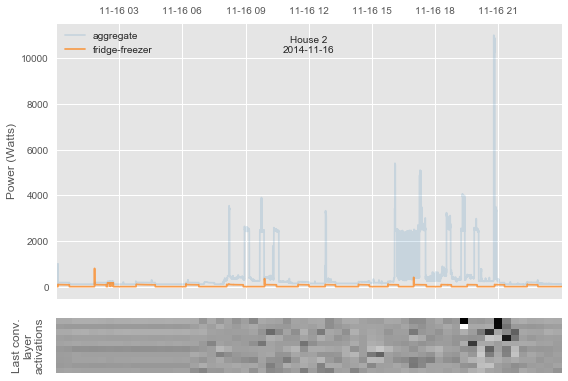

activations
kettle
actual = 4, predicted = 4.63043260574
shape of activations: (10, 60)


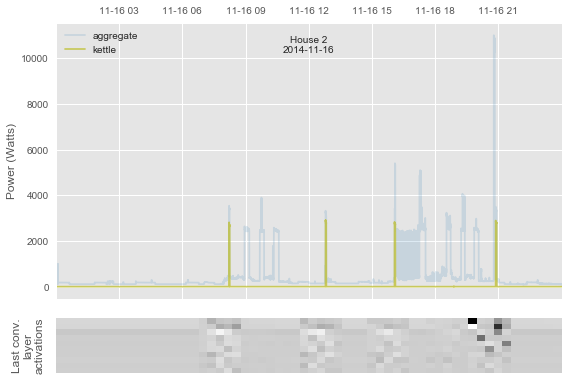

activations
washing machine
actual = 1, predicted = 1.48707807064
shape of activations: (10, 60)


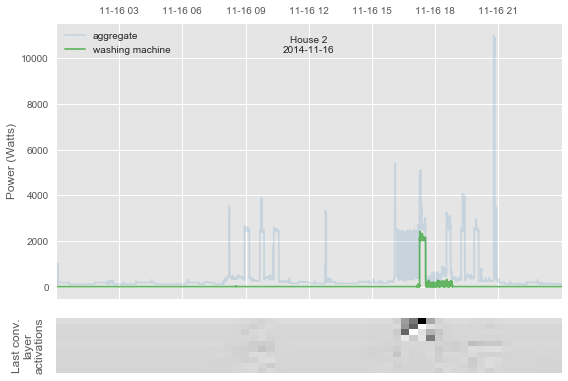

activations
dishwasher
actual = 2, predicted = 1.82526493073
shape of activations: (8, 8)


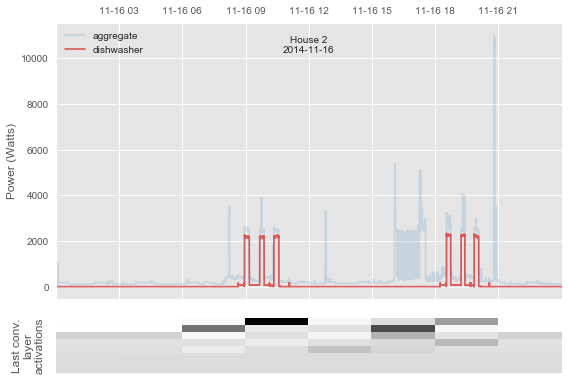

activations
microwave
actual = 4, predicted = 0.388577014208
shape of activations: (10, 225)


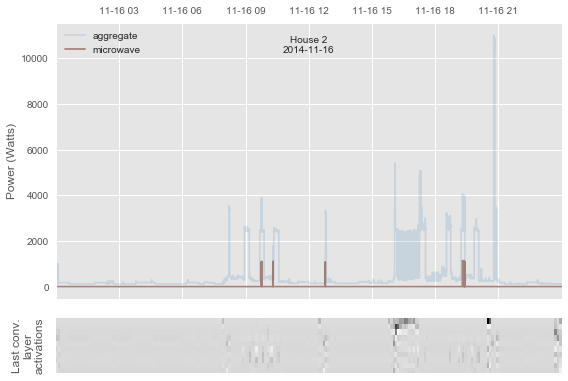

In [127]:
def plot_series_activations(
    activations,
    house_id,
    dt_start,
    dt_end=None,  # not implemented
    apps_to_plot=None,
    figsize=(8,5.5),
    height_ratios=[5, 1],
    alpha_aggregate=None,
    cmap_series=plt.cm.tab10,
    cmap_heatmap='Greys'
):
    '''
    TODO: Make so activations only represent times between dt_start and dt_end.
    (Right now I assume dt_start is the start of the day and that there's
    a full day of data.)
    '''
    
    # Define axes.
    
    gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=height_ratios)
    ax_series = fig.add_subplot(gs[0])
    ax_heatmap = fig.add_subplot(gs[1])
    
    # Plot series.
    plot_day(
        house_id,
        dt_start=dt_start,
        dt_end=dt_end,
        apps_to_plot=apps_to_plot,
        ax=ax_series,
        cmap=cmap_series,
        alpha_aggregate=alpha_aggregate)
    ax_series.get_xaxis().set_ticks_position('top')

    # Plot heatmap of activations.
    sns.heatmap(activations, ax=ax_heatmap, cbar=False, cmap=cmap_heatmap)
    ax_heatmap.get_xaxis().set_visible(False)
    ax_heatmap.set_ylabel('Last conv.\nlayer\nactivations')
    ax_heatmap.set_yticklabels([])

    gs.tight_layout(fig)
    plt.show()
    
    return gs


# Plot conv. activations of intersting house/date combinations.

# 440 is good for washing machine & dishwasher
# 531 good for kettle
# 575 seems okay all-around
# 556 has nice kettle activations
# 19 has nice kettle activations
# 636 has nice and clear signals with decent activation maps

seen_obs = [531, 799, 739, 183, 575, 556, 19, 40, 554, 575, 544, 626, 1004]
conv_layer_index = -1
k = 10  # or None if you don't want to reduce dimensionality

# house_id = 7
# dt = datetime(2015,5,29)
# obs = np.where((all_data['test']['x_house']==house_id) & (all_data['test']['x_date']==dt.date()))[0][0]
obs = int(obs_scores['obs'].values[13])

print 'observation: {}'.format(obs)
# if obs in seen_obs:
#     raise ValueError('already saw this obs')

house_id = all_data['test']['x_house'][obs]
dt = date_to_datetime(all_data['test']['x_date'][obs])
series = all_data['test']['X'][obs]

plot_day(house_id, date_to_datetime(dt), figsize=(9.25,5.5))
plt.show()

for target_type in TARGET_TYPES:
    for app_name in APP_NAMES:
# for target_type in ['energy']:
#     for app_name in [APP_NAMES[2]]:
        
        Y, Y_hat = preds[target_type][app_name]['All'][0]  # take actual values instead of transformed
        print '='*25
        print '{}\n{}'.format(target_type, app_name)
        print 'actual = {}, predicted = {}'.format(Y[obs][0], Y_hat[obs][0])
        print '='*25
        
        model_truncated = truncate_model(models[target_type][app_name], conv_layer_index)
        activations = get_activations(series, model_truncated)
        if k is not None:
            activations = reduce_dims_activations(activations, k)
            
        print 'shape of activations: {}'.format(activations.shape)

        # plot_series_activations(house_id, date_to_datetime(dt), activations)
        plt.show()
        app_name_standardized = get_standardized_app_names(house_id, app_name)
        if len(app_name_standardized)==0:
            print 'this house doesn`t have this appliance'
            continue
        plot_series_activations(activations,
                                house_id, date_to_datetime(dt), 
                                apps_to_plot=['aggregate'] + list(get_standardized_app_names(house_id, app_name)),
                                alpha_aggregate=0.15
                                # figsize=(8,3.5), height_ratios=[5, 2]
                                )
        plt.show()

In [120]:
['washing machine'] + [APP_NAMES]

['kettle', ['fridge', 'kettle', 'washing machine', 'dishwasher', 'microwave']]

/Users/sipola/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


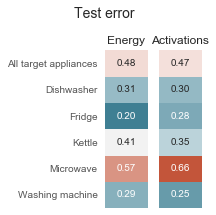

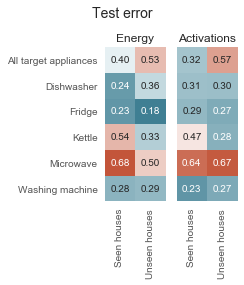

In [245]:
### Print LaTeX tables and heatmaps of performance metrics.

# sns.set_style('white')

def 

for house_type_idx, house_type_cols in enumerate([['All'], ['Seen houses', 'Unseen houses']]):

    # house_type_idx==0 means all, while ==1 means split
    
    # Construct performance DataFrame. Don't need to do this every 
    # iteration but it's cheap anyway. Keeps the namespace a bit cleaner.
    perf_df = []
    for target_type in TARGET_TYPES:
        perf_this_df = pd.DataFrame.from_dict(perf[target_type], orient='index')
        perf_this_df['Target type'] = target_type
        perf_df.append(perf_this_df)
    perf_df = pd.concat(perf_df)
    
    # Subset for house types we want.
    perf_df = perf_df[house_type_cols + ['Target type']]
    
    figsize = (3,3) if house_type_idx==0 else (3.5,4)

    fig, axes = plt.subplots(1, 2, sharex=False, sharey=True, figsize=figsize)
    # cmap = sns.diverging_palette(10, 220, sep=80, n=7, as_cmap=True)
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
    vmin = perf_df[house_type_cols].min().min()
    vmax = perf_df[house_type_cols].max().max()

    # Get data for target type and plot heatmap.
    for i, target_type in enumerate(TARGET_TYPES):
        perf_target = perf_df.loc[perf_df['Target type']==target_type]
        perf_target.index = map(lambda x: x.capitalize(), perf_target.index)
        perf_target.drop('Target type', axis=1, inplace=True)
        ax = axes.flat[i]
        if house_type_idx == 0:
            perf_target.columns = ['']  # remove axis label "All"
        sns.heatmap(perf_target, ax=ax, annot=True, square=False, cmap=cmap,
                    vmin=vmin, vmax=vmax, cbar=False, fmt='0.2f')
        ax.set_title(target_type.capitalize(), size=12)
    
    # Add title.
    fig.tight_layout()
    plt.subplots_adjust(top=0.78 if house_type_idx==0 else 0.84)
    fig.suptitle('Test error', size=14)
    
    # Save.
    makedirs2(dir_run)
    plt.savefig(os.path.join(dir_run, 'test_error_heatmap_{}.pdf'.format('all' if house_type_idx==0 else 'split')))
    
    plt.show()

    
# perf_df = []
# for target_type in TARGET_TYPES:
#     perf_this_df = pd.DataFrame.from_dict(perf[target_type], orient='index')
#     perf_this_df['Target type'] = target_type
#     perf_df.append(perf_this_df)

# perf_df = pd.concat(perf_df)

# perf_target['Difference'] = perf_target['Unseen houses'] - perf_target['Seen houses']
# perf_target['Difference (%)'] = perf_target['Difference'] / perf_target['Seen houses']

# plt.close()
# for target_type in TARGET_TYPES:
    
    # perf_target = perf_df.loc[perf_df['Target type']==target_type]
    # perf_target.drop('Target type', axis=1, inplace=True)
    
    # perf_target['Difference'] = perf_target['Unseen houses'] - perf_target['Seen houses']
    # perf_target['Difference (%)'] = perf_target['Difference'] / perf_target['Seen houses']

    # sns.heatmap(perf_target, annot=True, square=True, cmap=cmap)
    # plt.show()
    
    # # Need this in latex document: \newcommand*\rot{\rotatebox{90}}
    # t = []
    # t.append('\\centering')
    # t.append('\\begin{tabular}{' + ' l | ' + 'c '*perf_target.shape[1] + '}')
    # cols = [v for v in perf_target.columns.values]
    # t.append(' & ' + ' & '.join(cols) + ' \\\\')
    # t.append('\\hline')
    # for i, row in enumerate(perf_target.iterrows()):
    #     app_name_pretty = perf_target.index.values[i]
    #     row_pretty = ['{:0.3f}'.format(Decimal(v)) for v in row[1].values]
    #     row_pretty = [app_name_pretty] + row_pretty
    #     t.append(' & '.join(row_pretty) + ' \\\\')
    # t.append('\\end{tabular}')

    # print '\n'
    # print target_type
    # print '\n'
    # print '\n'.join(t)
    
# matplotlib.style.use('ggplot')

In [261]:
def make_pred_scatter_title(target_type, app_names):
    '''Convenience function for creating plot title.'''
    title = []
    if target_type == 'energy':
        title.append('Predictions vs. actual values\nTarget type: energy use (kWh)')
    else:
        title.append('Predictions vs. actual values\nTarget type: number of activations')
    title.append('\nAppliance: {}'.format(app_names[0]))
    title = ''.join(title)
    return title

energy
    fridge
    starting plot...
    kettle
    starting plot...
    washing machine
    starting plot...
    dishwasher
    starting plot...
    microwave
    starting plot...
    all target appliances
    starting plot...
activations
    fridge
    starting plot...
    kettle
    starting plot...
    washing machine
    starting plot...
    dishwasher
    starting plot...
    microwave
    starting plot...
    all target appliances
    starting plot...


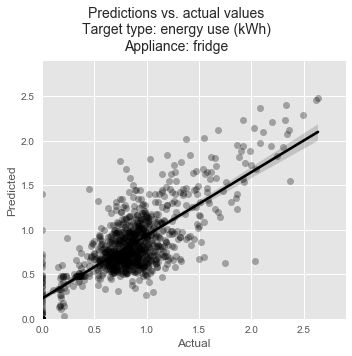

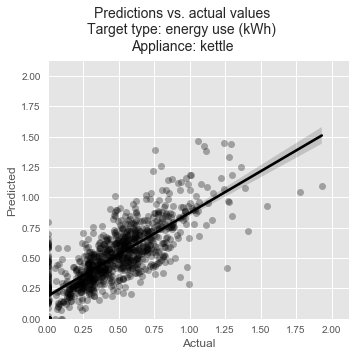

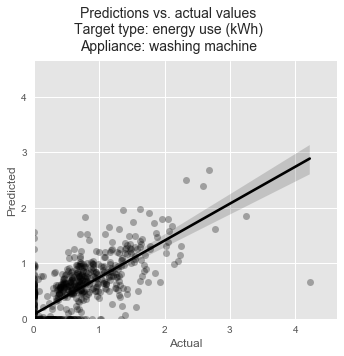

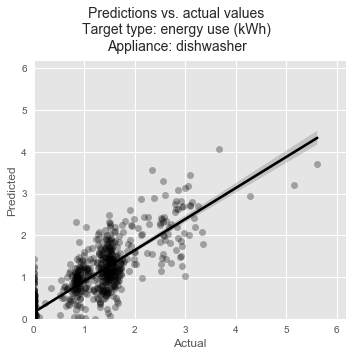

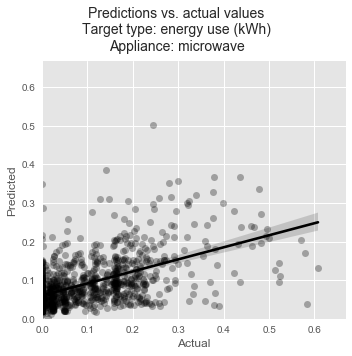

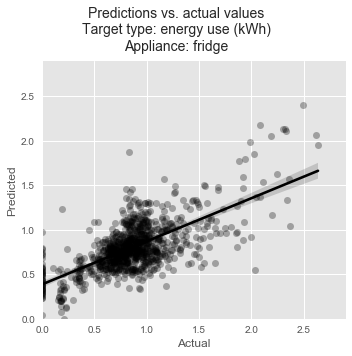

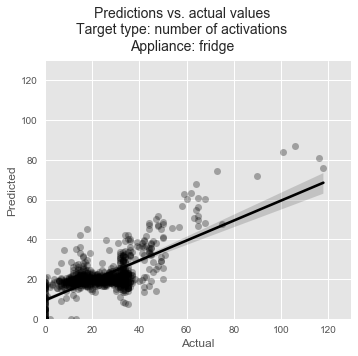

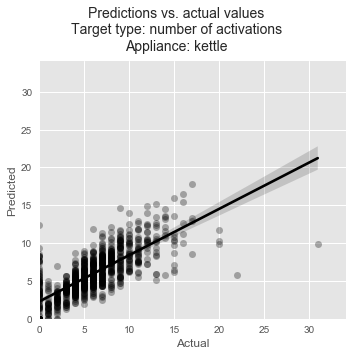

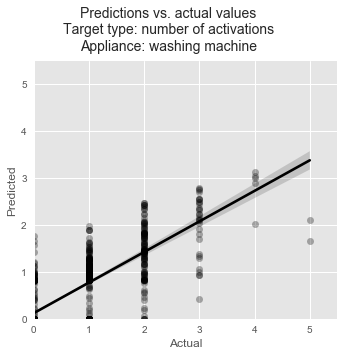

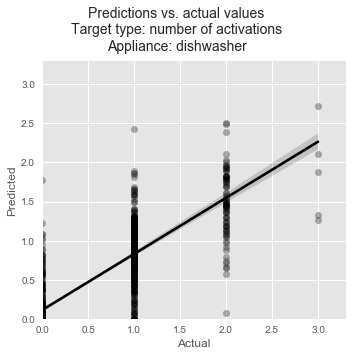

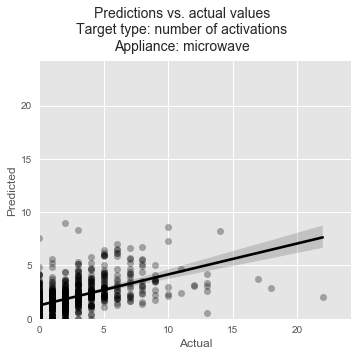

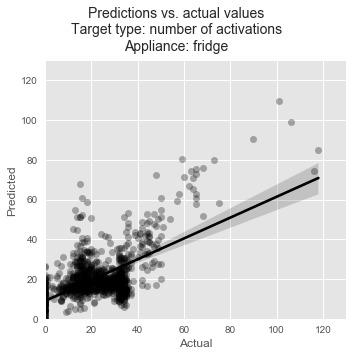

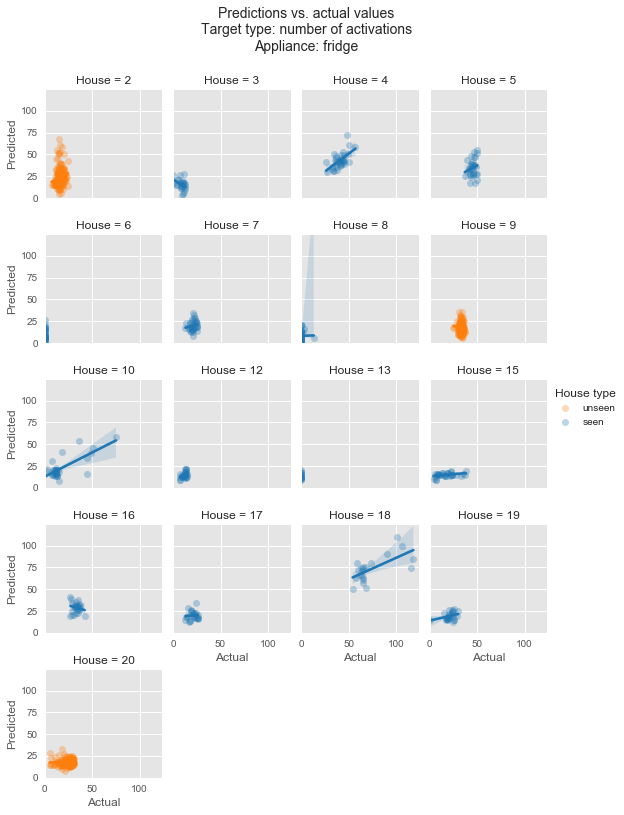

In [267]:
# Plot scatterplots of actual vs. predicted.

modeling_group_name = 'main'
data_set = 'test'

# app_names_list = [[a] for a in APP_NAMES] + [APP_NAMES]
app_names_list = [[a] for a in APP_NAMES]
target_app_idx = 2

perf = {}
for target_type in TARGET_TYPES:
    print target_type
    Y_key = 'Y1' if target_type=='energy' else 'Y2'
    for app_names in app_names_list:
        
        app_names_pretty = app_names_to_plot_name(app_names)
        print '    {}'.format(app_names_pretty)
        
        app_idx = [APP_NAMES.index(app_name) for app_name in app_names]
        
        # Get model objects.
        dir_models_set = os.path.join(dir_models, modeling_group_name, target_type, app_names_to_filename(app_names))
        model_name = get_best_model_name(dir_models_set)
        model = load_best_model(dir_models_set)
        target_scaler = pickle.load(open(os.path.join(dir_models_set, model_name, 'target_scaler.pkl'), 'rb'))
        
        if len(app_idx) == 1:
            target_app_idx = 0
        
        # Get actual and predictions.
        x_house = all_data[data_set]['x_house']
        y = all_data[data_set][Y_key][:,app_idx][:,target_app_idx]
        y_hat = target_scaler.inverse_transform(model.predict(reshape_as_tensor(all_data[data_set]['X'])))[:,target_app_idx]
        if all(y_hat[0] == y_hat):
            warnings.warn('all predicted values are the same!')
        
        title = make_pred_scatter_title(target_type, app_names)
        # print '        starting plot...'
        plot_pred_scatter(
            y = y,
            y_hat = y_hat,
            x_house = x_house,
            save_dir = dir_run,
            # palette = palette,
            title = title
        )

In [131]:
modeling_group_name = 'main'
target_type = 'activations'
app_names = ['washing machine']
# app_names = APP_NAMES

dir_models_set = os.path.join(dir_models, modeling_group_name, target_type, app_names_to_filename(app_names))
hist_and_params = get_histories_df(dir_models_set)
# hist_and_params

In [132]:
model_name = get_best_model_name(dir_models_set)
model = load_best_model(dir_models_set)
target_scaler = pickle.load(open(os.path.join(dir_models_set, model_name, 'target_scaler.pkl'), 'rb'))

In [133]:
hist_and_params[[
    'epoch',
    'val_loss',
    'runtime',
    'num_conv_layers',
    'num_dense_layers',
    'start_filters',
    'kernel_size',
    'strides',
    'pool_size',
    'last_dense_layer_size',
    'learning_rate',
    'l2_penalty'
]].head()

,epoch,val_loss,runtime,num_conv_layers,num_dense_layers,start_filters,kernel_size,strides,pool_size,last_dense_layer_size,learning_rate,l2_penalty
model,,,,,,,,,,,,
model_44,36,0.246813,83.585289,6,2,7,4,1,3,19,0.000374282,0
model_20,34,0.254789,95.811673,5,2,5,9,1,3,10,0.00140301,1.32784e-05
model_22,24,0.270973,147.959526,5,2,11,4,1,3,10,0.00117283,0
model_14,27,0.278025,347.257541,4,1,28,7,1,4,20,0.000336549,0.000413538
model_39,27,0.282377,48.280589,5,1,9,5,2,2,12,0.000918925,0


In [551]:
model_truncated = truncate_model(model)

In [263]:
row = 12

data_set = 'test'

Y_key = 'Y1' if target_type=='energy' else 'Y2'

series = all_data[data_set]['X'][row]
house_id = all_data[data_set]['x_house'][row]
dt = all_data[data_set]['x_date'][row]
activations = get_activations(series, model_truncated)

print all_data[data_set][Y_key][row]
print target_scaler.inverse_transform(get_activations(series, model))
print 'activations.shape: {}'.format(activations.shape)

print model_truncated.summary()

# ax.get_yaxis().set_visible(False)

[18  1  4  1  0]
[ 3.04652143]
activations.shape: (80, 178)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 14400, 5)          50        
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 4800, 5)           0         
_________________________________________________________________
conv_1 (Conv1D)              (None, 4800, 10)          460       
_________________________________________________________________
pool_1 (MaxPooling1D)        (None, 1600, 10)          0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 1600, 20)          1820      
_________________________________________________________________
pool_2 (MaxPooling1D)        (None, 534, 20)           0         
_________________________________________________________________
conv_3 (Conv1D) 

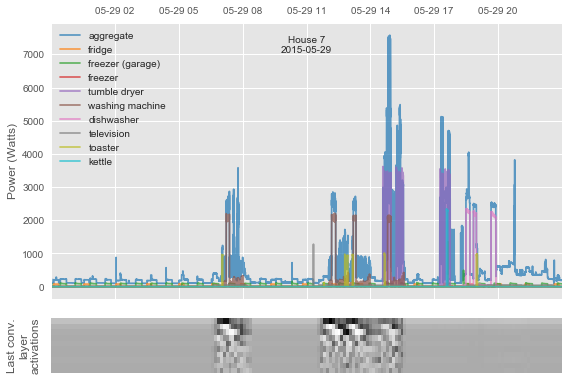

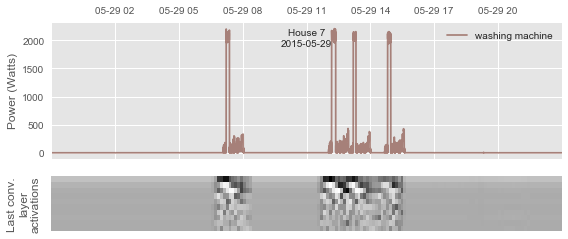

In [376]:
# row 10 of test (house 7, 2015-05-29) for good washing machine and dishwasher activations.

k = 10
# activations_pca = activations[np.random.choice(activations.shape[0], k, replace=False)]
activations_pca = PCA(k).fit_transform(activations.T).T
activations_pca = activations_pca - activations_pca.min()  # scale so min is zero

plot_series_activations(house_id, date_to_datetime(dt), activations_pca)
plot_series_activations(house_id, date_to_datetime(dt), activations_pca,
                        apps_to_plot=get_standardized_app_names(house_id, app_names[0]),
                        figsize=(8,3.5), height_ratios=[5, 2])

In [295]:
# app_idx2 = 2
# app_idx2 = list(app_idx)
target_app_idx = 2
if len(app_idx) == 1:
    target_app_idx = 0
y_val = all_data['test'][Y_key][:,app_idx][:,target_app_idx]
y_hat = target_scaler.inverse_transform(model.predict(reshape_as_tensor(all_data['test']['X'])))[:,target_app_idx]
if all(y_hat[0] == y_hat):
    print 'all predicted values are the same!'

NameError: name 'app_idx' is not defined

In [265]:
# # sns.distplot(np.log2(y+1))
# # sns.distplot(y, color='black')

# value_to_plot = y_val

# plot_empir_cum(value_to_plot)
# plt.show()
# sns.distplot(value_to_plot, color='black', hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
# plt.show()
# sns.distplot(value_to_plot, color='black')
# plt.show()

# # for i in range(Y.shape[1]):
# #     ax = sns.distplot(Y[:,i], color='black')
# #     ax.set_title('{}, actual'.format(APP_NAMES[i]))
# #     plt.show()
# #     ax = sns.distplot(Y_hat[:,i], color='black')
# #     ax.set_title('{}, predicted'.format(APP_NAMES[i]))
# #     plt.show()

In [ ]:
split_key = 'test'
target_app_idx = 2
if len(app_idx) == 1:
    target_app_idx = 0
y = all_data[split_key][Y_key][:,app_idx][:,target_app_idx]
print 'getting prediction data...'
y_hat = target_scaler.inverse_transform(model.predict(reshape_as_tensor(all_data[split_key]['X'])))[:,target_app_idx]
x_house = all_data[split_key]['x_house']

In [43]:
all_data.keys()

['val', 'synth_train_all', 'test_seen', 'test_unseen', 'real_train']

creating data for plot...

creating plot...
saving plot...


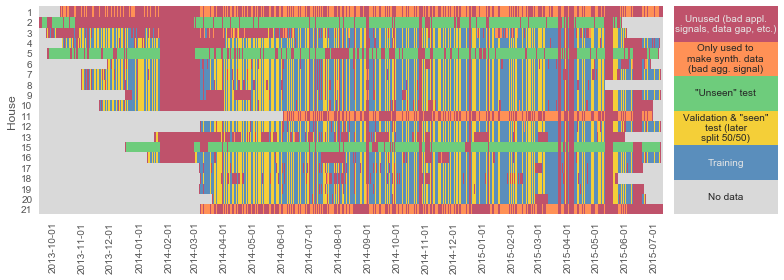

In [187]:
# Plot data split and quality heatmap.
print 'creating data for plot...'

style = 'landscape'

if style=='landscape':
    figsize=(11,4)
else:
    figsize=(4,10)

dstats2 = dstats.copy()
print 
dstats2 = dstats2[['House', 'Delete', 'Delete_BadAgg']]
dstats2.reset_index(inplace=True)
dstats2.columns = dstats2.columns.droplevel(1)

split_df = []
for split_type, type_id in {'real_train': 1, 'val': 2, 'test_seen': 2, 'test_unseen': 3}.iteritems():
    split_info = pd.DataFrame({
        'House': all_data[split_type]['x_house'],
        'Time': np.array(all_data[split_type]['x_date'], dtype=np.datetime64),
        'Type': type_id
    })
    split_df.append(split_info)
split_df = pd.concat(split_df)
dstats2 = pd.merge(dstats2, split_df, how='left', on=['House', 'Time'])

# Sort out solar business. Take into account fact that solar was simply
# removed earlier instead of setting Delete_BadAgg==1
dstats2.loc[dstats2['House'].isin(HOUSE_IDS_SOLAR), 'Delete_BadAgg'] = 1
# dstats2.loc[dstats2['House'].isin(HOUSE_IDS_SOLAR), 'Type'] = 1

# print set(dstats.loc[(dstats['Delete_BadAgg']==1) & (dstats['Delete']!=1), 'House'].values)

# print dstats2.loc[dstats2['House'].isin(HOUSE_IDS_NOT_SOLAR)].head()
# print dstats2.loc[dstats2['House'].isin(HOUSE_IDS_NOT_SOLAR)].tail()

dstats2.loc[(dstats2['Delete_BadAgg']==1) & \
            (dstats2['House'].isin(HOUSE_IDS_NOT_TEST_UNSEEN)) & \
            (dstats2['Time'].isin(train_dates)), 'Type'] = 4  # since bad aggs are not found in data sets

dstats2.loc[(dstats2['Delete_BadAgg']==1) & (dstats2['Type']==1), 'Type'] = 4  # only used in synthetic data
# print dstats2.loc[(dstats2['Delete_BadAgg']==1) & ~(dstats2['Type']==4) & (dstats2['Delete']==0)]
dstats2.loc[(dstats2['Delete_BadAgg']==1) & ~(dstats2['Type']==4), 'Type'] = 5  # ideally would've included these in synth creation but it was difficult to implement
dstats2.loc[dstats2['Delete']==1, 'Type'] = 5

dstats2['Date'] = map(lambda x: x, dstats2['Time'])
dstats2 = dstats2.pivot(index='Date', columns='House', values='Type')  # cast for heatmap
dstats2[pd.isnull(dstats2)] = 0  # get rid of nulls (heatmaps doesn't like them)

# Construct cmap.
colors = [
    '#5A8EBC',  # blue
    '#F4CF38',  # yellow
    '#6ECC7C',  # green
    '#FF9156',  # orange
    '#BF526B'   # red
]  # https://coolors.co/5a8ebc-6ecc7c-ff9156-f4cf38-bf526b
colors = [[.85, .85, .85]] + colors
my_cmap = ListedColormap(sns.color_palette(colors).as_hex())

fig = plt.figure(figsize=figsize)
if style=='landscape':
    gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[6, 1])
else:
    gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[9, 1])
ax = plt.subplot(gs[0])
cax = plt.subplot(gs[1])

labels = [
    'No data',
    'Training',
    'Validation & "seen"\ntest (later\nsplit 50/50)',
    '"Unseen" test',
    'Only used to\nmake synth. data\n(bad agg. signal)',
    'Unused (bad appl.\nsignals, data gap, etc.)'
]

cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=my_cmap)
cbar.ax.set_yticklabels(''*len(labels))  # vertically oriented colorbar
cbar.outline.set_visible(False)

# https://stackoverflow.com/a/15913419/4794432
for j, lab in enumerate(labels):
    color = '0.9' if j in [1,5] else '0.15'
    cbar.ax.text(.5, (2 * j + 1) / 12.0, lab, ha='center', va='center', color=color)  # for 6 colors

# Make date ticks pretty.
ticklabels = [dt64_to_datetime(d).date() if dt64_to_datetime(d).day==1 else '' for d in dstats2.index.values]

print 'creating plot...'
if style=='landscape':
    args = {'xticklabels': ticklabels}
    dstats2 = dstats2.T
else:
    args = {'yticklabels': ticklabels}
    
sns.heatmap(dstats2,
            cmap=my_cmap,
            ax=ax,
            cbar=False,
            **args)

# ax.set_title('Data split and data quality', size=14)
if style=='landscape':
    ax.set_xlabel('')
else:
    ax.set_ylabel('')

fig.tight_layout()

makedirs2(dir_run)
print 'saving plot...'
plt.savefig(os.path.join(dir_run, 'data_split_and_quality.pdf'))

In [425]:
tmp = np.random.normal(size=1000) + 10
print tmp
mu = np.mean(tmp)
print mu

[  9.57811531  11.01247239  10.18456972  10.4302757   10.88465025
  11.09370529  10.39857581   9.49597205  10.85551704   9.84373378
   9.56740395   9.59252851  10.2407202   10.48207968   9.82767469
  10.90827317   9.56670621  10.30143857  10.71247881  11.03461643
  11.69911664  11.18812519   9.99630088  10.76790608   8.9769217
  10.60865807   9.59115782  10.37865494   9.35347383  10.09285439
  11.97962223   9.73958545  10.58527438   9.78978035  11.05708406
  10.66085783  10.20190712  11.88873495   9.24184623   9.29843878
   8.91324909  10.58447181  10.64578359   9.24536499  10.07015372
   9.17121581   8.72256675   9.23777975  10.40229203   9.14491501
   8.69111772  10.42266509   8.78457113   9.25773652   9.65076192
  12.06725021   9.59930201   9.08917607  10.78372447  10.85677989
   7.56455273  10.20185871  11.69735811  10.93697314  11.55637464
  10.63800197   9.71659288   9.50656659  10.53356793   9.85771036
  10.51301581  10.66397997   9.01600249   9.7100391   10.7584269
   9.0128308

In [426]:
tmp = tmp / np.std(tmp)

In [427]:
tmp2 = np.random.normal(size=1000) + 10
print tmp2
mu2 = np.mean(tmp2)
print mu2

[  9.21016712  11.19537646   9.26933802   9.83151385  10.37583768
  10.19427583  10.51052221  10.15663627  10.35808302   9.68855122
  10.50400633   9.64781174   9.19120734  11.51022695  11.26479484
  10.07715411   8.83005552   9.84326047   9.13238627  10.73973529
  10.73374033  10.21804222   8.3789583   11.3962515    9.88133873
  10.34008035  10.12814566   9.47497367  11.10197485  10.24628328
   7.92400431  11.38647794  10.85806559   9.43567217   9.63608899
  11.17243331   9.44969726  12.10232155  11.36307721   9.92324349
   9.97479636   9.81836897  12.18184465  10.28815679  11.85576103
  10.63824573   9.72088432  10.91053304  10.26647697  10.38972953
   8.7722565   11.08343564   9.21856622  10.45269975   9.16629364
   9.54103113  10.1049425   10.26192495   9.64102196  10.1500985
  11.55439475  11.50579716   9.17641814   8.19175912  11.31050084
   8.44557366  10.48758336  10.94409837   7.67007976   9.68694134
  10.92813666   9.59183136  10.20304834   7.68484303   9.94998396
   8.896245

In [428]:
np.mean((tmp2 - mu)**2)

0.98788389722508585

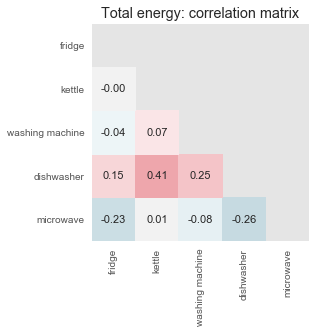

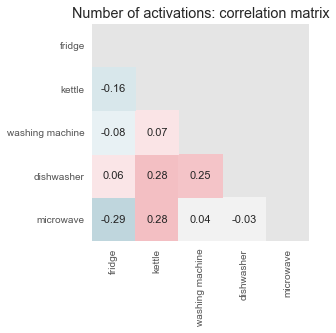

In [271]:
# Compute correlations between target variables.

def create_target_heatmap(Y, names, title=None, figsize=(5,4),
                          linewidths=0, annot=True, fmt='.2f'):

    # http://seaborn.pydata.org/examples/many_pairwise_correlations.html

    # Compute the correlation matrix.
    Y_df = pd.DataFrame(Y)
    Y_df.columns = APP_NAMES
    corr = Y_df.corr()

    # Generate a mask for the upper triangle.
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure.
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap.
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio.
    ax = sns.heatmap(corr, mask=mask, cmap=cmap, annot_kws={"fontsize":11}, fmt=fmt,
                annot=annot, square=True, linewidths=linewidths, ax=ax, cbar=False)
    ax.set_title(title)

data_set = 'test'
create_target_heatmap(all_data[data_set]['Y1'], APP_NAMES, title='Total energy: correlation matrix')
create_target_heatmap(all_data[data_set]['Y2'], APP_NAMES, title='Number of activations: correlation matrix')

In [16]:
# Plot confusion matrix by using seaborn heatmap function
def plot_confusion_matrix(cm, normalize=False, classes=None, title='Confusion matrix'):
    """
    Credit: Data Mining and Exploration course at University of Edinburgh
    https://github.com/agamemnonc/dme/blob/master/04_Lab_4_Performance_evaluation_model_selection_solution.ipynb
    
    Plots a confusion matrix.
    
    If normalize is set to True, the rows of the confusion matrix are normalized so that they sum up to 1.
    
    """
    if normalize is True:
        cm = cm/cm.sum(axis=1)[:, np.newaxis]
        vmin, vmax = 0., 1.
        fmt = '.2f'
    else:
        vmin, vmax = None, None
        fmt = 'd'
    sns.heatmap(cm, annot=True, fmt=fmt, annot_kws={"fontsize":11}, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(np.around(y_val), np.around(y_hat))
print cm

# Your code goes here
fig = plt.figure(figsize=(9,4))
ax1 = fig.add_subplot(121)
plot_confusion_matrix(cm, normalize=False) # un-normalized
ax2 = fig.add_subplot(122)
plot_confusion_matrix(cm, normalize=True, title='Normalized confusion matrix') # normalized
ax2.get_yaxis().set_visible(False)
fig.tight_layout()

NameError: name 'y_val' is not defined

In [ ]:
# "How convolutional neural networks see the world":
#     https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html
# 

model.get_layer('conv_2')

In [ ]:
# Check where targets were normal but predictions were extreme.
extreme_y_hat_cutoff = 10

bad_idx = np.where(y_hat > extreme_y_hat_cutoff)[0]
print 'num extreme predictions: {}'.format(len(bad_idx))

i = 0  # change this
print 'extreme prediction {}'.format(i)

house_id = val_data[x_house_idx][bad_idx][i]
d = val_data[x_date_idx][bad_idx][i]
energy = val_data[Y_idx][:,app_idx][bad_idx][i]
print 'actual energy: {}, predicted: {}'.format(energy, y_hat[bad_idx][i])

plot_day(house_id, date_to_datetime(d), figsize=(15,8))

In [ ]:
# Check where targets were extreme but predictions were too low.
extreme_y_cutoff = 2

bad_idx = np.where(y_val > extreme_y_cutoff)[0]
print 'num extreme predictions: {}'.format(len(bad_idx))

i = 1  # change this
print 'extreme prediction {}'.format(i)

house_id = val_data[x_house_idx][bad_idx][i]
d = val_data[x_date_idx][bad_idx][i]
energy = val_data[Y_idx][:,app_idx][bad_idx][i]
print 'actual energy: {}, predicted: {}'.format(energy, y_hat[bad_idx][i])

plot_day(house_id, date_to_datetime(d), figsize=(15,8))

In [ ]:
# val_data[X_idx][0]
i = 21
app_name = 'washing machine'

app_idx = APP_NAMES.index(app_name)

plot_series(val_data[X_idx][i])
house_id = val_data[x_house_idx][i]
d = val_data[x_date_idx][i]
energy1 = val_data[Y_idx][i][app_idx]
print house_id, d, energy1

plot_day(house_id, date_to_datetime(d))
energy2 = get_energy(dstats, house_id, d, get_app_nums(house_id, app_name))
print energy2